In [6]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
from tqdm import tqdm
import openai
import time

start_time = time.time()

PATH = "./regenerated/results_reddit.json"
METHOD = "Cosine Similarity"
DATA = "ELI5_Minimum_600"

#! Certify
openai.api_key = "API_KEY"
os.environ['AZURE_OPENAI_ENDPOINT'] = "API_ENDPOINT"
openai.api_type = "azure"
openai.api_version = "API_DATE"


print("Loading Data...")
#! Load Data from file
data = None
with open(PATH, "r") as f:
    data = json.load(f)
print(f"{len(data)} generated texts loaded.")

Loading Data...
2156 generated texts loaded.


In [2]:
from sentence_transformers import util, SentenceTransformer
import statistics
from nltk.stem.porter import PorterStemmer
from utils import tokenize

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

human_scores = []
ai_scores = []

for idx in tqdm(range(len(data))):
	current_data = []
	if data[idx]["masked_generated"] == None or len(data[idx]["masked_original"]) == 0: continue

	tokenized_original = ' '.join(tokenize(data[idx]["masked_original"], stemmer=PorterStemmer()))
	embedding_original = model.encode(tokenized_original, convert_to_tensor=True)
	
	for generated_sample in data[idx]["masked_generated"]:
		if generated_sample == None: continue
		tokenized_generated = ' '.join(tokenize(generated_sample, stemmer=PorterStemmer()))
		try:
			embedding_generated = model.encode(tokenized_generated, convert_to_tensor=True)
		except Exception as e:
			print(e)
			continue

		res = util.pytorch_cos_sim(embedding_original, embedding_generated)
		current_data.append(res.item())
	
	if len(current_data) == 0: continue
	if data[idx]["type"] == "ai":
		ai_scores.append(statistics.mean(current_data))
	else:
		human_scores.append(statistics.mean(current_data))

/home/ajr07/.pyenv/versions/3.11.0/envs/EDMaL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ajr07/.pyenv/versions/3.11.0/envs/EDMaL/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 2986/2986 [06:11<00:00,  8.04it/s]


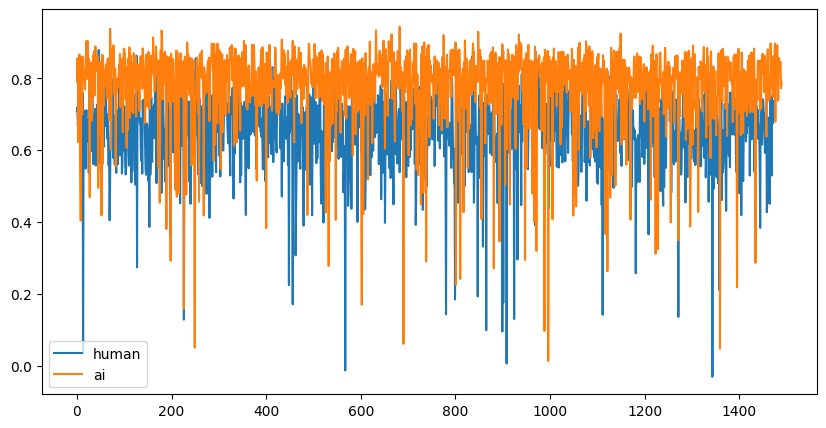

In [3]:
#! Plot Results
plt.figure(figsize=(10, 5))
plt.plot(human_scores, label='human')
plt.plot(ai_scores, label='ai')
plt.legend()
plt.show()

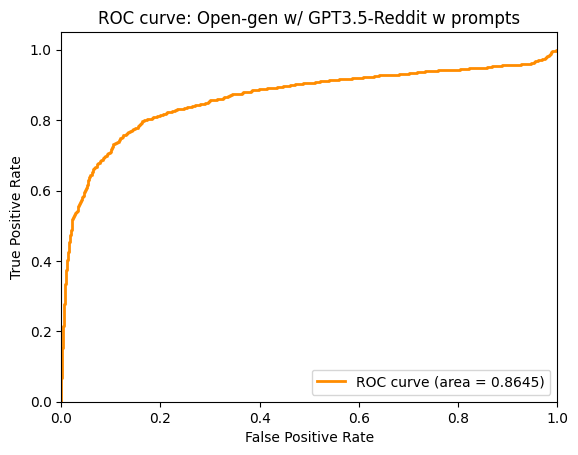

TPR at 1% FPR: 0.27447894312388094


In [4]:
#! ROC Curve Plotting
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A = human_scores
    B = gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    json.dump([(fpr[i], tpr[i], thresholds[i]) for i in range(len(thresholds))], open(f"test.json", "w+"))
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()

    # find the closest fpr more than 1% fpr
    coords1 = (0, 0)
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > 0.01:
            coords1 = (float(fpr[idx]), float(tpr[idx]))
            break
    
    coords2 = (0, 0)
    for idx, fpr_ in enumerate(reversed(fpr)):
        if fpr_ < 0.01:
            coords2 = (float(fpr[len(fpr) - idx - 1]), float(fpr[len(fpr) - idx - 1]))
            break

    # (x1, y1) and (x2, y2)
    # Gradient = (y2 - y1) / (x2 - x1)
    # y = [(y2 - y1) / (x2 - x1)] (0.01 - x2) + y2
    tpr_at_one_fpr = ((coords2[1] - coords1[1]) / (coords2[0] - coords1[0])) * (0.01 - coords2[0]) + coords2[1]
    print(f"TPR at 1% FPR: {tpr_at_one_fpr}")

plot_roc_curve(human_scores, ai_scores)

In [5]:
# Save Results
import json

if not os.path.exists(f"./results/{DATA}"):
    os.makedirs(f"./results/{DATA}")

with open(f"./results/{DATA}/{METHOD}.json", "w+") as f:
	json.dump({"ai_scores": ai_scores, "human_scores": human_scores, "time": time.time() - start_time}, f)